## Training the Vision Transformer on a Custom Dataset

In this notebook, we are going to fine-tune a pre-trained Vision Transformer (which can be found from [Huggingface](https://github.com/huggingface/transformers)) on a Custom Dataset. For this notebook we will be using the Rock, Paper, Scissors dataset which can be found [here](https://public.roboflow.com/classification/rock-paper-scissors/1). This dataset is a collection of 2925 images images in 3 different classes. This tutorial is based on Huggingface's [Fine tuning the Vision Transformer on CIFAR 10 notebook](https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/VisionTransformer/Fine_tuning_the_Vision_Transformer_on_CIFAR_10_with_the_%F0%9F%A4%97_Trainer.ipynb).

### Accompanying Blog Post

We recommend that you follow along in this notebook while reading the blog post on [How to Train the HuggingFace Vision Transformer On a Custom Dataset](blog.roboflow.com/how-to-train-the-huggingface-vision-transformer-on-a-custom-dataset/) concurrently.


We will prepare the data using [Roboflow's Preprocessing Tools](https://docs.roboflow.com/image-transformations/image-preprocessing), and train the model using this notebook. 

### Steps Covered in this Tutorial

In this tutorial, we will walk through the steps required to train a Vision Transformer on your custom classification data.

To train our image classifier we take the following steps:

* Install Vision Transformer dependencies
* Download custom Image Classification data using Roboflow
* Use the Vision Transformer Feature Extractor
* Run the Vision Transformer training procedure
* Evaluate the Vision Transformer on a test image
* Export the Vision Transformer model for future inference


### **About**

[Roboflow](https://roboflow.com) enables teams to deploy custom computer vision models quickly and accurately. Convert data from to annotation format, assess dataset health, preprocess, augment, and more. It's free for your first 1000 source images.

**Looking for a vision model available via API without hassle? Try Roboflow Train.**

![Roboflow Wordmark](https://i.imgur.com/dcLNMhV.png)



Let's start by installing the relevant libraries.

In [1]:
!pip install  git+https://github.com/huggingface/transformers

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-dyr9kw4m
  Running command git clone -q https://github.com/huggingface/transformers /tmp/pip-req-build-dyr9kw4m
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for transformers: filename=transformers-4.22.0.dev0-py3-none-any.whl size=4703225 sha256=6e8083c89576512625acc3eeceeed30b7b3e86b7f4d5c64a1e420641fd54df67
  Stored in directory: /tmp/pip-ephem-wheel-cache-7ggpo9m3/wheels/42/68/45/c63edff61c292f2dfd4df4ef6522dcbecc603e7af82813c1d7
Successfully built transformers


# Download the Data 

We'll preprocess and download our dataset from Roboflow. To preprocess the images, change the size of the image to 224x224. To download the dataset, use the "**Folder Structure**" export format.

To get your data into Roboflow, follow the [Getting Started Guide](https://blog.roboflow.ai/getting-started-with-roboflow/).

Note: This data has already been preprocessed through Roboflow; we HIGHLY reccommend you follow the [accompanying blog](blog.roboflow.com/how-to-train-the-huggingface-vision-transformer-on-a-custom-dataset/) as you go through this notebook.

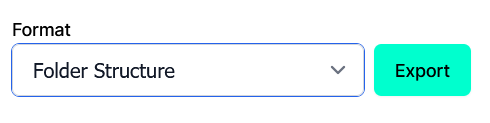

In [2]:
! curl -L "https://public.roboflow.com/ds/gftCVSMv3D?key=vwKEKfMVWU" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

/bin/bash: curl: command not found
/bin/bash: unzip: command not found


Next, convert the folder structure dataset into a PyTorch dataset format using PyTorch's ImageFolder dataset structure:

In [3]:
! pip install IProgress
import torchvision
from torchvision import transforms
import torch

Transform = transforms.Compose([transforms.Resize(size=(224, 224)), transforms.ToTensor()])
Full_Dataset = torchvision.datasets.ImageFolder('/root/vit/datasets/PETA', transform=Transform)
Full_Dataset

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset ImageFolder
    Number of datapoints: 16944
    Root location: /root/vit/datasets/PETA
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

In [4]:
## variables settings

Num_Lables = 2
Pre_Trained_Model = 'google/vit-base-patch16-224-in21k'
ViT_Feature_Extractor = 'google/vit-base-patch16-224-in21k'
EPOCHS = 10
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
Num_Workers = 4
SHUFFLE = True

In [5]:
import torch.utils.data as data
from torch.autograd import Variable
import numpy as np

train_size = int(0.8 * len(Full_Dataset))
test_size = len(Full_Dataset) - train_size
train_ds, test_ds = torch.utils.data.random_split(Full_Dataset, [train_size, test_size])


print("Number of train samples: ", len(train_ds))
print("Number of test samples: ", len(test_ds))
# print("Detected Classes are: ", train_ds.class_to_idx) 


# train_ds, test_ds = torch.utils.data.random_split(Full_Dataset,[14000, (16944-14000)] )

Number of train samples:  13555
Number of test samples:  3389


In [6]:
train_loader = data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=SHUFFLE,  num_workers=Num_Workers)
test_loader  = data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=SHUFFLE, num_workers=Num_Workers)
train_loader 

## Define the Model

Here we define the model.

The model itself uses a linear layer on top of a pre-trained `ViTModel`. We place a linear layer on top of the last hidden state of the [CLS] token, which serves as a good representation of an entire image. We also add dropout for regularization.

**Note:** The Vision Transformer pretrained model can be used as a regular PyTorch layer.


To train this model, we will train in 3 epochs, with a batch size of 10 and a learning rate of 2e-5:

In [7]:
from transformers import ViTModel
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn as nn
import torch.nn.functional as F
import tqdm as notebook_tqdm

class ViTForImageClassification(nn.Module):
    def __init__(self, num_labels=Num_Lables):
        super(ViTForImageClassification, self).__init__()
        self.vit = ViTModel.from_pretrained(Pre_Trained_Model)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_labels)
        self.num_labels = num_labels

    def forward(self, pixel_values, labels):
        outputs = self.vit(pixel_values=pixel_values)
        output = self.dropout(outputs.last_hidden_state[:,0])
        logits = self.classifier(output)

        loss = None
        if labels is not None:
          loss_fct = nn.CrossEntropyLoss()
          loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        if loss is not None:
          return logits, loss.item()
        else:
          return logits, None

## Define the Model Parameters


We will use the pretrained Vision Transformer feature extractor, an Adam Optimizer, and a Cross Entropy Loss function.

In [8]:
from transformers import ViTFeatureExtractor
import torch.nn as nn
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
print(device)
print(torch.cuda.is_available())

cuda
True


In [9]:
# Define Model
model = ViTForImageClassification(Num_Lables)    
# Feature Extractor
feature_extractor = ViTFeatureExtractor.from_pretrained(ViT_Feature_Extractor)
# Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# Cross Entropy Loss
loss_func = nn.CrossEntropyLoss()
# Use GPU if available  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
if torch.cuda.is_available():
    model.cuda() 

## Train the Model

In [10]:
# Train the model
acc = []
lss = []
ep = []
step = 1
for epoch in range(EPOCHS):        
  for step, (x, y) in enumerate(train_loader):
    # Change input array into list with each batch being one element
    x = np.array_split(np.squeeze(np.array(x)), BATCH_SIZE)
    # Remove unecessary dimension
    for index, array in enumerate(x):
      x[index] = np.squeeze(array)
    # Apply feature extractor, stack back into 1 tensor and then convert to tensor
    try:
      x = torch.tensor(np.stack(feature_extractor(x)['pixel_values'], axis=0))
      # Send to GPU if available
      x, y  = x.to(device), y.to(device)
      b_x = Variable(x)   # batch x (image)
      b_y = Variable(y)   # batch y (target)
      # Feed through model
      output, loss_train = model(b_x, None)
      # Calculate loss
      if loss_train is None: 
        loss_train = loss_func(output, b_y)   
        
        optimizer.zero_grad()           
        loss_train.backward()                 
        optimizer.step()
      # train_losses.append(loss_train.item())
      if step % 50 == 0:
        # Get the next batch for testing purposes
        test = next(iter(test_loader))
        test_x = test[0]
        # Reshape and get feature matrices as needed
        try:
          test_x = np.array_split(np.squeeze(np.array(test_x)), BATCH_SIZE)
          for index, array in enumerate(test_x):
            test_x[index] = np.squeeze(array)
          test_x = torch.tensor(np.stack(feature_extractor(test_x)['pixel_values'], axis=0))
          # Send to appropirate computing device
          test_x = test_x.to(device)
          test_y = test[1].to(device)
          # Get output (+ respective class) and compare to target
          test_output, loss_test = model(test_x, test_y)
          # val_losses.append(loss_test.item())
          test_output = test_output.argmax(1)
          # Calculate Accuracy
          accuracy = (test_output == test_y).sum().item() / BATCH_SIZE
          # accuracy_all.append(accuracy)
          print('Epoch: ', epoch, '| train loss: %.4f' % loss_train, '| test accuracy: %.2f' % accuracy)
          acc.append(accuracy)
          ep.append(step)
          step = step + 1
          lss.append(loss_train)
        except:
          print("Error Test")
    except:

      print("Error Train")

Epoch:  0 | train loss: 0.6722 | test accuracy: 0.66
Epoch:  0 | train loss: 0.5398 | test accuracy: 0.81
Epoch:  0 | train loss: 0.3410 | test accuracy: 0.84
Epoch:  0 | train loss: 0.1829 | test accuracy: 0.88
Epoch:  0 | train loss: 0.2388 | test accuracy: 0.91
Epoch:  0 | train loss: 0.4323 | test accuracy: 0.88
Epoch:  0 | train loss: 0.1815 | test accuracy: 0.91
Epoch:  0 | train loss: 0.2208 | test accuracy: 1.00
Epoch:  0 | train loss: 0.1833 | test accuracy: 0.81
Error Train
Epoch:  1 | train loss: 0.1344 | test accuracy: 0.88
Epoch:  1 | train loss: 0.0527 | test accuracy: 0.94
Epoch:  1 | train loss: 0.1461 | test accuracy: 0.91
Epoch:  1 | train loss: 0.0594 | test accuracy: 1.00
Epoch:  1 | train loss: 0.1921 | test accuracy: 0.84
Epoch:  1 | train loss: 0.1341 | test accuracy: 0.94
Epoch:  1 | train loss: 0.3928 | test accuracy: 0.91
Epoch:  1 | train loss: 0.0862 | test accuracy: 0.97
Epoch:  1 | train loss: 0.0317 | test accuracy: 1.00
Error Train
Epoch:  2 | train loss

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

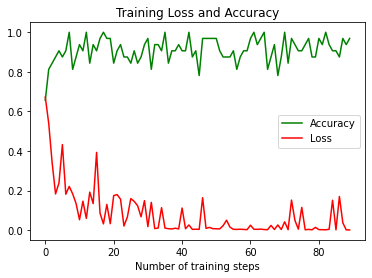

In [50]:
import matplotlib.pyplot as plt
cpu_lss = []
[cpu_lss.append(i.item()) for i in lss ]
fig, ax = plt.subplots()
# ax.legend(loc='upper left')
ax.set_title('Training Loss and Accuracy')
# ax.set_xlabel('Year')
ax.set_xlabel('Number of training steps')
plt.plot(range(len(ep)), acc, 'g',range(len(ep)), cpu_lss,'r')
legend_drawn_flag = True
plt.legend(['Accuracy', 'Loss'], loc=0, frameon=legend_drawn_flag)
plt.show()

## Evaluate on a Test Image

Finally, let's evaluate the model on a test image:

In [30]:
import matplotlib.pyplot as plt
import numpy as np


import torchvision
from torchvision import transforms
import torch


MODEL_PATH = 'model.pt'
model = torch.load(MODEL_PATH)
model.eval()

Transform = transforms.Compose([transforms.Resize(size=(224, 224)), transforms.ToTensor()])
valid_ds = torchvision.datasets.ImageFolder('/root/vit/MIT-IB', transform=Transform)
# print(valid_ds)
Actual_Labels = []
Predicted_Labels = [] 
EVAL_BATCH = 1
eval_loader  = data.DataLoader(valid_ds, batch_size=EVAL_BATCH, shuffle=True, num_workers=4) 
print(len(eval_loader), device)
# break
# Disable grad
with torch.no_grad():
  # for step, (inputs, target) in enumerate(train_loader):
  for i in range(len(eval_loader)):
  #  for i in range(10):
    inputs, target = next(iter(eval_loader))
    # Reshape and get feature matrices as needed
    # print(inputs.shape)
    # break
    inputs = inputs[0].permute(1, 2, 0)
    # Save original Input
    originalInput = inputs
    for index, array in enumerate(inputs):
      inputs[index] = np.squeeze(array)
    inputs = torch.tensor(np.stack(feature_extractor(inputs)['pixel_values'], axis=0))

    # Send to appropriate computing device
    inputs = inputs.to(device)
    target = target.to(device)
  
    # Generate prediction
    prediction, loss = model(inputs, target)
      
    # Predicted class value using argmax
    predicted_class = np.argmax(prediction.cpu())
    # print(prediction, target)
    # value_predicted = list(valid_ds.class_to_idx.keys())[list(valid_ds.class_to_idx.values()).index(predicted_class)]
    # value_target = list(valid_ds.class_to_idx.keys())[list(valid_ds.class_to_idx.values()).index(target)]

    value_predicted = list(valid_ds.class_to_idx.values())[list(valid_ds.class_to_idx.values()).index(predicted_class)]
    value_target = list(valid_ds.class_to_idx.values())[list(valid_ds.class_to_idx.values()).index(target)]

    Actual_Labels.append(value_target)
    Predicted_Labels.append(value_predicted)

    # print(value_predicted==value_target)
    print(f'Image - {i}, Prediction: {value_predicted} - Actual target: {value_target}; {value_predicted==value_target}')
    # Show result
    # plt.imshow(originalInput)
    # plt.xlim(224,0)
    # plt.ylim(224,0)
    # plt.title(f'Prediction: {value_predicted} - Actual target: {value_target}')
    # plt.show()

888 cuda
Image - 0, Prediction: 1 - Actual target: 1; True
Image - 1, Prediction: 1 - Actual target: 1; True
Image - 2, Prediction: 1 - Actual target: 1; True
Image - 3, Prediction: 1 - Actual target: 1; True
Image - 4, Prediction: 0 - Actual target: 0; True
Image - 5, Prediction: 0 - Actual target: 0; True
Image - 6, Prediction: 1 - Actual target: 1; True
Image - 7, Prediction: 1 - Actual target: 1; True
Image - 8, Prediction: 1 - Actual target: 1; True
Image - 9, Prediction: 1 - Actual target: 1; True
Image - 10, Prediction: 1 - Actual target: 1; True
Image - 11, Prediction: 1 - Actual target: 1; True
Image - 12, Prediction: 1 - Actual target: 1; True
Image - 13, Prediction: 1 - Actual target: 1; True
Image - 14, Prediction: 0 - Actual target: 1; False
Image - 15, Prediction: 0 - Actual target: 0; True
Image - 16, Prediction: 1 - Actual target: 1; True
Image - 17, Prediction: 1 - Actual target: 1; True
Image - 18, Prediction: 0 - Actual target: 0; True
Image - 19, Prediction: 0 - Act

In [31]:
! pip install -q torchmetrics
import torch
from torchmetrics import Accuracy
target = torch.tensor(Actual_Labels)
preds = torch.tensor(Predicted_Labels)
accuracy = Accuracy()
accuracy(preds, target)

tensor(0.9167)

In [41]:
from torchmetrics import ConfusionMatrix

target = torch.tensor(Actual_Labels)
preds = torch.tensor(Predicted_Labels)
# target

confmat = ConfusionMatrix(num_classes=2)
confmat(preds, target)

tensor([[253,  40],
        [ 34, 561]])

In [47]:
from torchmetrics import ROC
roc = ROC(num_classes=None)
fpr, tpr, thresholds = roc(preds, target)
print(fpr, tpr, thresholds)

tensor([0.0000, 0.1365, 1.0000]) tensor([0.0000, 0.9429, 1.0000]) tensor([2, 1, 0])


/usr/local/lib/python3.8/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `ROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [55]:
from torchmetrics.functional import precision_recall
# preds  = torch.tensor([2, 0, 2, 1])
# target = torch.tensor([1, 1, 2, 0])
print(precision_recall(preds, target, average='weighted', num_classes=2))

print(precision_recall(preds, target, average='macro', num_classes=2))

(tensor(0.9163), tensor(0.9167))
(tensor(0.9075), tensor(0.9032))


In [56]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

## Save the Entire Model

We can save the entire model as follows:

In [11]:
torch.save(model, 'model.pt')

In [10]:
# Train the model
for epoch in range(EPOCHS):        
  for step, (x, y) in enumerate(train_loader):
    # Change input array into list with each batch being one element
    x = np.array_split(np.squeeze(np.array(x)), BATCH_SIZE)
    # Remove unecessary dimension
    for index, array in enumerate(x):
      x[index] = np.squeeze(array)
    # Apply feature extractor, stack back into 1 tensor and then convert to tensor
    try:
      x = torch.tensor(np.stack(feature_extractor(x)['pixel_values'], axis=0))
      # Send to GPU if available
      x, y  = x.to(device), y.to(device)
      b_x = Variable(x)   # batch x (image)
      b_y = Variable(y)   # batch y (target)
      # Feed through model
      output, loss = model(b_x, None)
      # Calculate loss
      if loss is None: 
        loss = loss_func(output, b_y)   
        
        optimizer.zero_grad()           
        loss.backward()                 
        optimizer.step()

      if step % 50 == 0:
        # Get the next batch for testing purposes
        test = next(iter(test_loader))
        test_x = test[0]
        # Reshape and get feature matrices as needed
        try:
          test_x = np.array_split(np.squeeze(np.array(test_x)), BATCH_SIZE)
          for index, array in enumerate(test_x):
            test_x[index] = np.squeeze(array)
          test_x = torch.tensor(np.stack(feature_extractor(test_x)['pixel_values'], axis=0))
          # Send to appropirate computing device
          test_x = test_x.to(device)
          test_y = test[1].to(device)
          # Get output (+ respective class) and compare to target
          test_output, loss = model(test_x, test_y)
          
          test_output = test_output.argmax(1)
          # Calculate Accuracy
          accuracy = (test_output == test_y).sum().item() / BATCH_SIZE
          print('Epoch: ', epoch, '| train loss: %.4f' % loss, '| test accuracy: %.2f' % accuracy)
        except:
          print("Error Test")
    except:
      print("Error Train")

NameError: name 'train_loader' is not defined

In [7]:
import matplotlib.pyplot as plt
import numpy as np


import torchvision
from torchvision import transforms
import torch


MODEL_PATH = 'model.pt'
model = torch.load(MODEL_PATH)
model.eval()

Transform = transforms.Compose([transforms.Resize(size=(224, 224)), transforms.ToTensor()])
valid_ds = torchvision.datasets.ImageFolder('/root/vit/datasets/cdset_gender', transform=Transform)
# print(valid_ds)
Actual_Labels = []
Predicted_Labels = [] 
EVAL_BATCH = 1
eval_loader  = data.DataLoader(valid_ds, batch_size=EVAL_BATCH, shuffle=True, num_workers=4) 
print(len(eval_loader), device)
# break
# Disable grad
with torch.no_grad():
  # for step, (inputs, target) in enumerate(train_loader):
  for i in range(len(eval_loader)):
  #  for i in range(10):
    inputs, target = next(iter(eval_loader))
    # Reshape and get feature matrices as needed
    # print(inputs.shape)
    # break
    inputs = inputs[0].permute(1, 2, 0)
    # Save original Input
    originalInput = inputs
    for index, array in enumerate(inputs):
      inputs[index] = np.squeeze(array)
    inputs = torch.tensor(np.stack(feature_extractor(inputs)['pixel_values'], axis=0))

    # Send to appropriate computing device
    inputs = inputs.to(device)
    target = target.to(device)
  
    # Generate prediction
    prediction, loss = model(inputs, target)
      
    # Predicted class value using argmax
    predicted_class = np.argmax(prediction.cpu())
    # print(prediction, target)
    # value_predicted = list(valid_ds.class_to_idx.keys())[list(valid_ds.class_to_idx.values()).index(predicted_class)]
    # value_target = list(valid_ds.class_to_idx.keys())[list(valid_ds.class_to_idx.values()).index(target)]

    value_predicted = list(valid_ds.class_to_idx.values())[list(valid_ds.class_to_idx.values()).index(predicted_class)]
    value_target = list(valid_ds.class_to_idx.values())[list(valid_ds.class_to_idx.values()).index(target)]

    Actual_Labels.append(value_target)
    Predicted_Labels.append(value_predicted)

    # print(value_predicted==value_target)
    print(f'Image - {i}, Prediction: {value_predicted} - Actual target: {value_target}; {value_predicted==value_target}')
    # Show result
    # plt.imshow(originalInput)
    # plt.xlim(224,0)
    # plt.ylim(224,0)
    # plt.title(f'Prediction: {value_predicted} - Actual target: {value_target}')
    # plt.show()

350 cuda
Image - 0, Prediction: 0 - Actual target: 0; True
Image - 1, Prediction: 0 - Actual target: 0; True
Image - 2, Prediction: 1 - Actual target: 1; True
Image - 3, Prediction: 1 - Actual target: 1; True
Image - 4, Prediction: 1 - Actual target: 1; True
Image - 5, Prediction: 1 - Actual target: 1; True
Image - 6, Prediction: 0 - Actual target: 0; True
Image - 7, Prediction: 0 - Actual target: 0; True
Image - 8, Prediction: 1 - Actual target: 1; True
Image - 9, Prediction: 1 - Actual target: 1; True
Image - 10, Prediction: 1 - Actual target: 0; False
Image - 11, Prediction: 1 - Actual target: 1; True
Image - 12, Prediction: 0 - Actual target: 0; True
Image - 13, Prediction: 1 - Actual target: 1; True
Image - 14, Prediction: 0 - Actual target: 0; True
Image - 15, Prediction: 0 - Actual target: 1; False
Image - 16, Prediction: 1 - Actual target: 1; True
Image - 17, Prediction: 1 - Actual target: 1; True
Image - 18, Prediction: 0 - Actual target: 0; True
Image - 19, Prediction: 1 - Ac

In [8]:
from torchmetrics import ConfusionMatrix

target = torch.tensor(Actual_Labels)
preds = torch.tensor(Predicted_Labels)
# target

confmat = ConfusionMatrix(num_classes=2)
confmat(preds, target)

tensor([[147,  32],
        [  6, 165]])

In [9]:
import torch
from torchmetrics import Accuracy
target = torch.tensor(Actual_Labels)
preds = torch.tensor(Predicted_Labels)
accuracy = Accuracy()
accuracy(preds, target)

tensor(0.8914)